# Counte mRNA inside Tracking Cells

In [2]:
using FileIO, Images
using ImageSegmentation
using Plots
using Random
using Distributions
using GaussianMixtures
using Statistics

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1260
  likely near /home/hf/.julia/packages/Images/0SDGT/src/Images.jl:60
┌ Info: Precompiling ImageSegmentation [80713f31-8817-5129-9cf8-209ff8fb23e1]
└ @ Base loading.jl:1260
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1260
┌ Info: Precompiling GaussianMixtures [cc18c42c-b769-54ff-9e2a-b28141a64aae]
└ @ Base loading.jl:1260


In [3]:
function get_random_color(seed)
    Random.seed!(seed)
    rand(RGB{N0f8})
end

get_random_color (generic function with 1 method)

In [4]:
"""
Generate border form watershed result
"""
#function watershedborder(watershed_segments::SegmentedImage{Array{Int64,2},Float64} )
function watershedborder(watershed_segments)
    marker_border = BitArray(undef, size(watershed_segments.image_indexmap));
    marker_border .=false
    #marker_border = zeros(Int8, size(watershed_segments.image_indexmap));
    for label in watershed_segments.segment_labels
        marker_border .|= ((watershed_segments.image_indexmap.==label) .⊻ erode(watershed_segments.image_indexmap .==label));
    end
    marker_border;
end

watershedborder (generic function with 1 method)

In [5]:
data_dir = "/datahub/rawdata/tandeng/mRNA_imaging/mRNA_confocal_hamamatsu-60X-TIRF";
img_15_1 = load(File(format"TIFF", "$data_dir/20200315/HE7-11-1-80uw-const_1_s1.ome.btf.tiff"));

In [7]:
img_16_2 = load(File(format"TIFF", "$data_dir/20200316/HE7-11-1-80uw-PWM_1_s2.ome.tiff"));

# 3. LoG, Distance Map

In [112]:
"""
Use LoG without Distance Map fiter raw image to extract cell
"""
function split_cell_LoG(stack::Array{Gray{Normed{UInt16,16}},3}, time::Int)
    img_edge = zeros(N0f16, 1900, 1300, time);
    img_clear = zeros(N0f16, 1900, 1300, time);
    for i in 1:time
        imgx = mapwindow(median!, stack[:, :, 20*i+14], (5,5));
        imgx_log = imfilter(imgx, Kernel.LoG(40)) .< -1e-7 ;
        imgx_dist = distance_transform(feature_transform(imgx_log)) .^ 0.5;
        imgx_markers = label_components( imgx_dist .< 5);
        #imgx_segments = watershed( imgx_dist, imgx_markers);  
        imgx_segments = watershed( imfilter(1 .- imgx, Kernel.gaussian(9)), imgx_markers);
        #imgout[:,:,i] = Gray.(imgx_segments.image_indexmap./maximum(imgx_segments.segment_labels));
        img_edge[:,:,i] = .~watershedborder(imgx_segments).*imgx;
        img_clear[:,:,i] = extract_nucleus( imgx, imgx_segments);
    end
	#map(i->get_random_color(i),labels_map(imgx_segments))]
    img_edge, img_clear;
end

split_cell_LoG

In [151]:
"""
Extract nucleus from sperated cell
"""
function extract_nucleus( img, watershed_segments::SegmentedImage{Array{Int64,2},Float64} )
    img_clear = zeros(N0f16, size(watershed_segments.image_indexmap));
    img_blur = imfilter(img, Kernel.gaussian(9));
    for label in watershed_segments.segment_labels
        cell = img_blur .* (watershed_segments.image_indexmap .== label);
        # only select 70% brigter region or fixed area
        gmm = GMM(3, [pixel for pixel in real(cell) if pixel > 1e-5]);
        nucleus_th = sort(gmm.μ, dims=1)[end-1];
        img_clear .+= ( remove_small_area(cell .> nucleus_th)) .*img;
    end
    img_clear;
end

"""
Just remove regions are small
"""
function remove_small_area(mask)
    mask_con = label_components(mask);
    mask_res = BitArray(undef, size(mask));
    mask_res .= false;cd
    for i in 1:maximum(mask_con)
        if sum(mask_con .== i) > 5e3
            mask_res .+= (mask_con.==i);
        end
    end
    mask_res;
end

extract_nucleus

In [298]:
"""
Use LoG without Distance Map fiter raw image to extract cell
"""
function split_cell_LoG(stack::Array{Gray{Normed{UInt16,16}},3}, time::Int)
    img_edge = zeros(N0f16, 1900, 1300, time);
    img_clear = zeros(N0f16, 1900, 1300, time*20);
    for i in 1:time
        imgx = mapwindow(median!, stack[:, :, 20*i+14], (5,5));
        imgx_log = imfilter(imgx, Kernel.LoG(40)) .< -1e-7 ;
        imgx_dist = distance_transform(feature_transform(imgx_log)) .^ 0.5;
        imgx_markers = label_components( imgx_dist .< 5);
        #imgx_segments = watershed( imgx_dist, imgx_markers);  
        imgx_segments = watershed( imfilter(1 .- imgx, Kernel.gaussian(9)), imgx_markers);
        #imgout[:,:,i] = Gray.(imgx_segments.image_indexmap./maximum(imgx_segments.segment_labels));
        img_edge[:,:,i] = .~watershedborder(imgx_segments).*imgx;
        img_clear_mask = extract_nucleus( imgx, imgx_segments) .> 0;
        for z in 1:20
            img_clear[:,:,(i-1)*20+z] = img_clear_mask .* stack[:,:,(i-1)*20+z]
        end
    end
	#map(i->get_random_color(i),labels_map(imgx_segments))]
    img_edge, img_clear;
end

split_cell_LoG

In [192]:
using HDF5

In [221]:
@time h5write("h5testall.h5", "img", rawview(real(reshape(img_15_1, 1900, 1300, 20, :))));
#h5writeattr("bar.h5", "foo", Dict("c"=>"value for metadata parameter c","d"=>"metadata d"))

 28.994724 seconds (18 allocations: 11.502 GiB, 0.09% gc time)


In [301]:
"""
Use LoG without Distance Map fiter raw image to extract cell, (vesion 3)
Export statistic data and find long-live cell
"""
function split_cell_LoG(stack::Array{Gray{Normed{UInt16,16}},3}, time::Int)
    img_edge = zeros(N0f16, 1900, 1300, time);
    img_clear = zeros(N0f16, 1900, 1300, time*20);
    mask_edge = zeros(Int16, 1900, 1300, time);
    mask_clear = zeros(Bool, 1900, 1300, time);
    
    for i in 1:time
        imgx = mapwindow(median!, stack[:, :, 20*i+14], (5,5));
        #imgx_log = imfilter(imgx.*(imgx.>(120/0xffff)), Kernel.LoG(40)) .< -1e-7 ;
        imgx_log = imfilter(imgx, Kernel.LoG(40)) .< -1e-7 ;
        imgx_dist = distance_transform(feature_transform(imgx_log)) .^ 0.5; #取阈值后再做？
        imgx_markers = label_components( imgx_dist .< 5); 
        #imgx_segments = watershed( imgx_dist, imgx_markers);  
        imgx_segments = watershed( imfilter(1 .- imgx, Kernel.gaussian(9)), imgx_markers); # 取阈值后再做？
        #imgout[:,:,i] = Gray.(imgx_segments.image_indexmap./maximum(imgx_segments.segment_labels));
        mask_edge[:,:,i] = imgx_segments.image_indexmap;
        img_edge[:,:,i] = .~watershedborder(imgx_segments).*imgx;
        img_clear_mask = extract_nucleus( imgx, imgx_segments) .> 0;
        mask_clear[:,:,i] = img_clear_mask;
        for z in 1:20
            img_clear[:,:,(i-1)*20+z] = img_clear_mask .* stack[:,:,(i-1)*20+z]
        end
    end
	#map(i->get_random_color(i),labels_map(imgx_segments))]
    img_edge, img_clear, mask_edge, mask_clear;
end

split_cell_LoG

In [ ]:
@time img_edge, img_clear, mask_edge, mask_clear = split_cell_LoG(img_16_2, 137);
save("mask4stat.jld","nucleus", mask_clear, "edge", mask_edge);
save("output/img_16_2_edge.tiff", img_edge);
save("output/img_16_2_clear.tiff", img_clear[:,:,1:20:end]);
#save("output/img_16_2_edge_z.tiff", edge);
#save("output/img_16_2_clear_z.tiff", clear);

In [ ]:
@time edge, clear = split_cell_LoG(img_15_1, 20);
save("output/img_15_1_edge.tiff", edge);
save("output/img_15_1_clear.tiff", clear);

In [ ]:
@time edge, clear = split_cell_LoG(img_16_2, 1);
save("output/img_16_2_edge_z.tiff", edge);
save("output/img_16_2_clear_z.tiff", clear);

In [ ]:
@time out = split_cell_LoG(img_16_2, 137);
save("output/img_16_2.tiff", out);

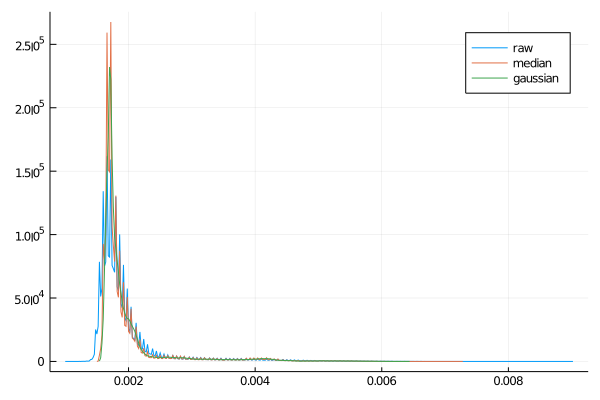

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to un

In [75]:
edges, count = imhist(img_15_1[:,:,11]); 
edges2, count2 = imhist(mapwindow(median!, img_15_1[:,:,0], (5,5)));
edges3, count3 = imhist(imfilter(img_15_1[:,:,10], Kernel.gaussian(3)));
gr()
plot(edges, count[2:end], label="raw");
plot!(edges2, count2[2:end], label="median")
plot!(edges3, count3[2:end], label="gaussian")